Columns: Index(['Date', 'LNG 145K CBM (Steam Turbine) Spot Rate (avg., $/day)',
       'LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)',
       'LNG Carrier Newbuilding Prices (end month, $m)',
       'LNG Orderbook (start month, CBM)', 'Aprox. Ship on order',
       'Global price of Natural Gas, Asia (start month, MMBTU)',
       'Global price of Natural Gas, EU (start month, MMBTU)',
       'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
       'Spread EU-US', 'Spread ASIA-US', 'Spread ASIA-EU'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 2019-01-01 to 2024-12-01
Freq: MS
Data columns (total 11 columns):
 #   Column                                                          Non-Null Count  Dtype  
---  ------                                                          --------------  -----  
 0   LNG 145K CBM (Steam Turbine) Spot Rate (avg., $/day)            72 non-null     float64
 1   LNG 174K CBM (2-stroke dual f

C:\Users\Eier\AppData\Local\Temp\ipykernel_10348\135394960.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x if x > 0 else 1)


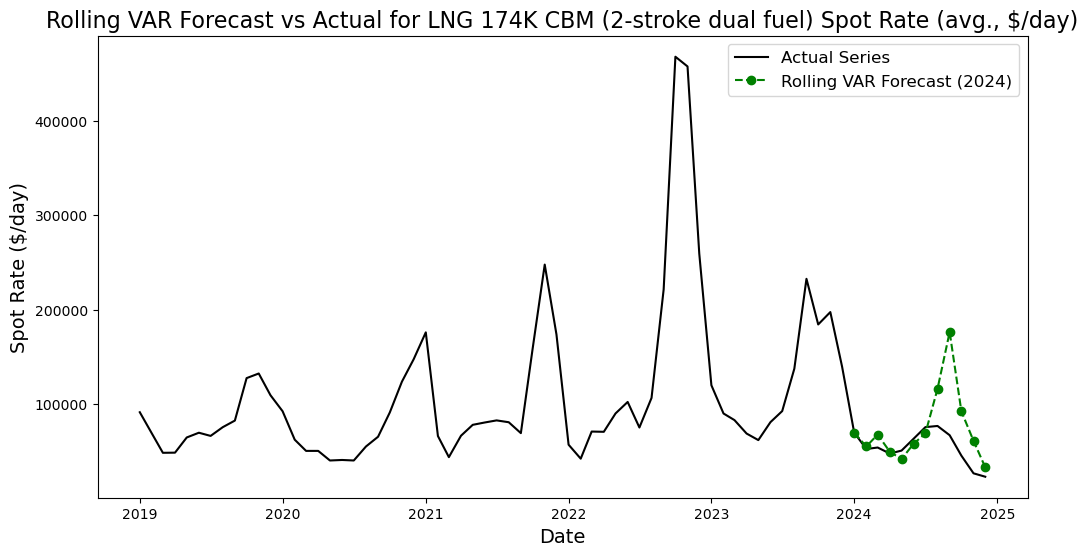

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
import csv

# 1. Load the CSV file
df = pd.read_csv("datatest.csv", sep=",", engine="python", quoting=csv.QUOTE_MINIMAL)

# 2. Clean column names: remove newline characters, extra spaces, and quotes
df.columns = df.columns.str.replace("\n", " ").str.strip().str.replace('"', '')
print("Columns:", df.columns)

# 3. Convert 'Date' to datetime (format like "Dec-14") and set as index
df['Date'] = pd.to_datetime(df['Date'], format='%b-%y', errors='coerce')
df = df.dropna(subset=['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)
df = df.asfreq('MS')  # Monthly Start Frequency

# 4. Convert all remaining columns to numeric and drop rows with missing values
df = df.apply(pd.to_numeric, errors='coerce').dropna()
print(df.info())

# 5. Ensure all values are positive. If any value is ≤ 0, replace with a small positive number (e.g., 1)
df = df.applymap(lambda x: x if x > 0 else 1)

# 6. Apply a log transformation to all columns (including the target)
df_log = np.log(df)

# 7. Define training (before 2024) and test (2024) sets (in log scale)
train_log = df_log[df_log.index < '2024-01-01']
test_log = df_log[(df_log.index >= '2024-01-01') & (df_log.index < '2025-01-01')]
print("Training set length:", len(train_log))
print("Test set length:", len(test_log))

# 8. Apply seasonal differencing with lag 12 on the log-transformed training data
train_diff = train_log.diff(12).dropna()

# Set the target variable (in original scale, this is the LNG 174K spot rate)
target_var = "LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)"

# 9. Rolling Forecast using an expanding window in log space
predictions_log = []
forecast_dates = []
actuals = []

for i in range(len(test_log)):
    # Expand the training set dynamically (in log scale)
    expanding_train_log = df_log.iloc[: train_log.index.shape[0] + i]
    expanding_diff = expanding_train_log.diff(12).dropna()
    
    if len(expanding_diff) < 2:
        print(f"Skipping forecast at {test_log.index[i]} due to insufficient data.")
        continue

    # Use a fixed lag (lag=1) for simplicity; you can try optimal lag selection if enough data exists.
    model = VAR(expanding_diff)
    try:
        var_model = model.fit(1)
    except ValueError:
        var_model = model.fit(1)
    
    # Forecast one step ahead (in the differenced log space)
    input_data = expanding_diff.values[-var_model.k_ar:]
    forecast_diff = var_model.forecast(y=input_data, steps=1)
    forecast_diff_df = pd.DataFrame(forecast_diff, columns=df_log.columns, index=[test_log.index[i]])
    
    # Reverse seasonal differencing:
    # For log-differenced series, the reversal is: forecasted log value = forecast_diff + log(value from 12 months ago)
    prev_date = test_log.index[i] - pd.DateOffset(months=12)
    if prev_date in expanding_train_log.index:
        reversal_value = expanding_train_log.loc[prev_date, target_var]
    else:
        reversal_value = expanding_train_log[target_var].iloc[-1]
    
    forecast_log_value = forecast_diff_df.iloc[0] + reversal_value

    predictions_log.append(forecast_log_value[target_var])
    actuals.append(test_log.loc[test_log.index[i], target_var])
    forecast_dates.append(test_log.index[i])

predictions_log = np.array(predictions_log)
actuals = np.array(actuals)

# Convert forecasts back to original scale by exponentiating
predictions_original = np.exp(predictions_log)
actuals_original = np.exp(actuals)

mse_log = np.mean((actuals_original - predictions_original)**2)
print(f"Rolling VAR Forecast MSE for {target_var} (log transform): {mse_log:.2f}")

# 10. Plot the entire actual series with the rolling forecast overlaid (on original scale)
plt.figure(figsize=(12,6))
plt.plot(df.index, df[target_var], label="Actual Series", color="black")
plt.plot(forecast_dates, predictions_original, label="Rolling VAR Forecast (2024)", linestyle="--", marker="o", color="green")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Spot Rate ($/day)", fontsize=14)
plt.title("Rolling VAR Forecast vs Actual for " + target_var, fontsize=16)
plt.legend(fontsize=12)
plt.show()


Columns: Index(['Date', 'LNG 145K CBM (Steam Turbine) Spot Rate (avg., $/day)',
       'LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)',
       'LNG Carrier Newbuilding Prices (end month, $m)',
       'LNG Orderbook (start month, CBM)', 'Aprox. Ship on order',
       'Global price of Natural Gas, Asia (start month, MMBTU)',
       'Global price of Natural Gas, EU (start month, MMBTU)',
       'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
       'Spread EU-US', 'Spread ASIA-US', 'Spread ASIA-EU'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 2019-01-01 to 2024-12-01
Freq: MS
Data columns (total 11 columns):
 #   Column                                                          Non-Null Count  Dtype  
---  ------                                                          --------------  -----  
 0   LNG 145K CBM (Steam Turbine) Spot Rate (avg., $/day)            72 non-null     float64
 1   LNG 174K CBM (2-stroke dual f

C:\Users\Eier\AppData\Local\Temp\ipykernel_10348\3237429691.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[target_var] = np.where(train[target_var] > upper_limit, upper_limit, train[target_var])
C:\Users\Eier\AppData\Local\Temp\ipykernel_10348\3237429691.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[target_var] = np.where(train[target_var] <= 0, 1, train[target_var])
C:\Users\Eier\anaconda3\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encounte

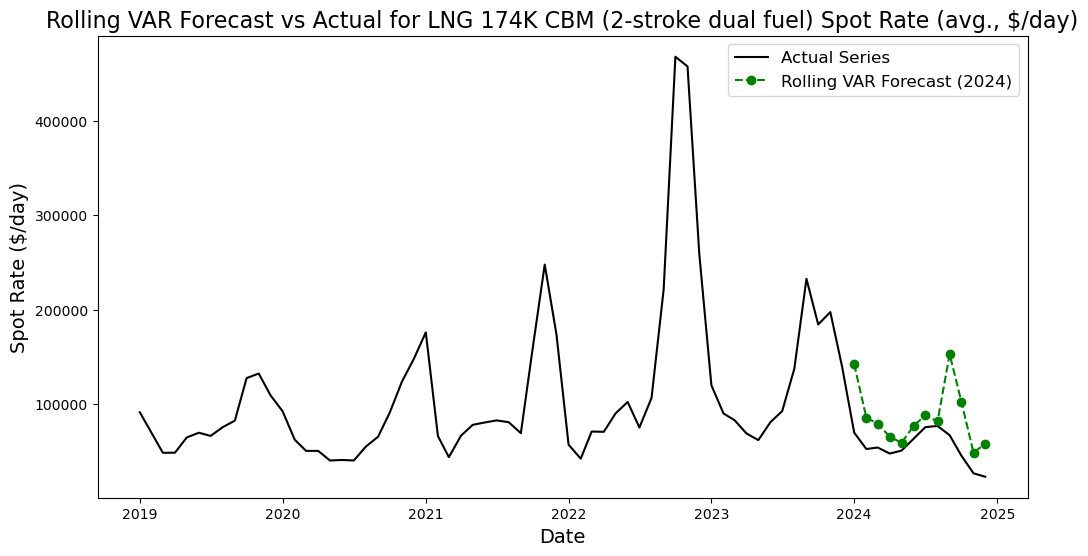

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
import csv

# 1. Load the CSV file
df = pd.read_csv("datatest.csv", sep=",", engine="python", quoting=csv.QUOTE_MINIMAL)

# 2. Clean the column names
df.columns = df.columns.str.replace("\n", " ").str.strip().str.replace('"', '')
print("Columns:", df.columns)

# 3. Convert 'Date' to datetime (e.g., "Dec-14") and set as index
df['Date'] = pd.to_datetime(df['Date'], format='%b-%y', errors='coerce')
df = df.dropna(subset=['Date'])  # Remove rows with invalid dates
df = df.sort_values('Date')
df.set_index('Date', inplace=True)
df = df.asfreq('MS')  # Monthly Start Frequency

# 4. Convert remaining columns to numeric and drop rows with missing values
df = df.apply(pd.to_numeric, errors='coerce').dropna()
print(df.info())

# 5. Define training (before 2024) and test (2024) sets (original scale)
train = df[df.index < '2024-01-01']
test = df[(df.index >= '2024-01-01') & (df.index < '2025-01-01')]
print("Training set length:", len(train))
print("Test set length:", len(test))

# 6. Winsorize the target variable in the training set to cap extreme peaks
target_var = "LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)"
upper_limit = train[target_var].quantile(0.90)
train[target_var] = np.where(train[target_var] > upper_limit, upper_limit, train[target_var])

# 7. Ensure all values are positive before log transform (replace non-positive with a small value)
df[target_var] = np.where(df[target_var] <= 0, 1, df[target_var])
train[target_var] = np.where(train[target_var] <= 0, 1, train[target_var])

# 8. Apply log transformation to the entire dataset
df_log = np.log(df)
train_log = df_log[df_log.index < '2024-01-01']
test_log = df_log[(df_log.index >= '2024-01-01') & (df_log.index < '2025-01-01')]

# 9. Apply seasonal differencing (lag 12) on the log-transformed training data
train_diff = train_log.diff(12).dropna()

# 10. Rolling Forecast in Log Space
predictions_log = []
forecast_dates = []
actuals_log = []

for i in range(len(test_log)):
    # Expand the training set (log space) for an expanding window
    expanding_train_log = df_log.iloc[: train_log.index.shape[0] + i]
    expanding_diff = expanding_train_log.diff(12).dropna()
    
    if len(expanding_diff) < 2:
        print(f"Skipping forecast at {test_log.index[i]} due to insufficient data.")
        continue
    
    # Use a fixed lag of 1 (if data is limited)
    model = VAR(expanding_diff)
    try:
        var_model = model.fit(1)
    except ValueError:
        var_model = model.fit(1)
    
    # Forecast one step ahead in differenced log space
    input_data = expanding_diff.values[-var_model.k_ar:]
    forecast_diff = var_model.forecast(y=input_data, steps=1)
    forecast_diff_df = pd.DataFrame(forecast_diff, columns=df_log.columns, index=[test_log.index[i]])
    
    # Reverse seasonal differencing: add the log value from 12 months ago
    prev_date = test_log.index[i] - pd.DateOffset(months=12)
    if prev_date in expanding_train_log.index:
        reversal_value = expanding_train_log.loc[prev_date, target_var]
    else:
        reversal_value = expanding_train_log[target_var].iloc[-1]
    
    forecast_log_value = forecast_diff_df.iloc[0] + reversal_value
    
    predictions_log.append(forecast_log_value[target_var])
    actuals_log.append(test_log.loc[test_log.index[i], target_var])
    forecast_dates.append(test_log.index[i])

predictions_log = np.array(predictions_log)
actuals_log = np.array(actuals_log)

# 11. Convert forecasts back to original scale (exponentiate)
predictions_original = np.exp(predictions_log)
actuals_original = np.exp(actuals_log)

mse_log = np.mean((actuals_original - predictions_original)**2)
print(f"Rolling VAR Forecast MSE for {target_var} (with winsorization & log transform): {mse_log:.2f}")

# 12. Plot the actual series with the rolling forecast overlaid
plt.figure(figsize=(12,6))
plt.plot(df.index, df[target_var], label="Actual Series", color="black")
plt.plot(forecast_dates, predictions_original, label="Rolling VAR Forecast (2024)", linestyle="--", marker="o", color="green")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Spot Rate ($/day)", fontsize=14)
plt.title("Rolling VAR Forecast vs Actual for " + target_var, fontsize=16)
plt.legend(fontsize=12)
plt.show()


Columns: Index(['Date', 'LNG 145K CBM (Steam Turbine) Spot Rate (avg., $/day)',
       'LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)',
       'LNG Carrier Newbuilding Prices (end month, $m)',
       'LNG Orderbook (start month, CBM)', 'Aprox. Ship on order',
       'Global price of Natural Gas, Asia (start month, MMBTU)',
       'Global price of Natural Gas, EU (start month, MMBTU)',
       'Global price of Natural Gas, US Henry Hub (start month, MMBTU)',
       'Spread EU-US', 'Spread ASIA-US', 'Spread ASIA-EU'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 2019-01-01 to 2024-12-01
Freq: MS
Data columns (total 11 columns):
 #   Column                                                          Non-Null Count  Dtype  
---  ------                                                          --------------  -----  
 0   LNG 145K CBM (Steam Turbine) Spot Rate (avg., $/day)            72 non-null     float64
 1   LNG 174K CBM (2-stroke dual f

C:\Users\Eier\AppData\Local\Temp\ipykernel_10348\1568953291.py:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x if x > 0 else 1)


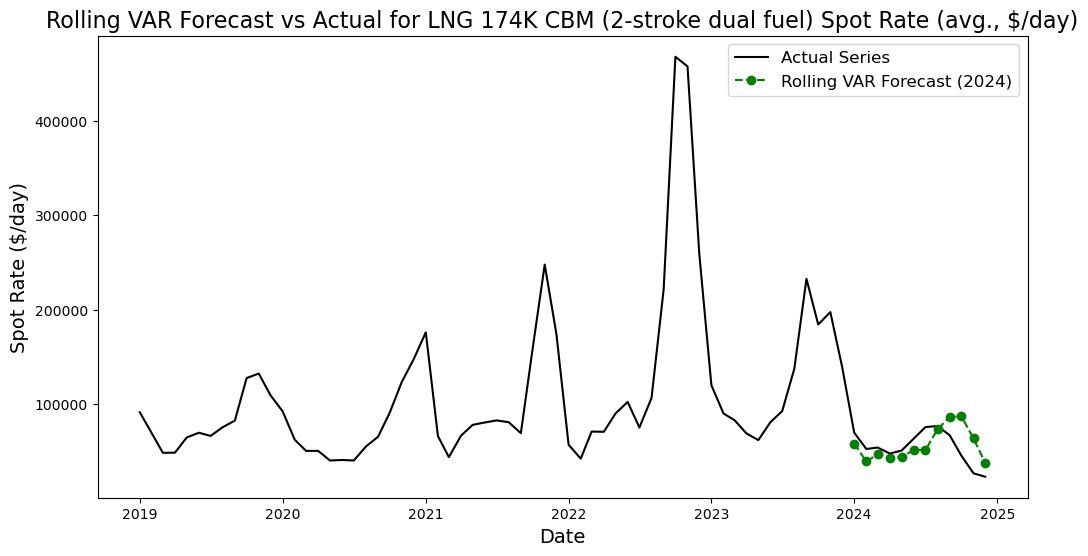

In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
import csv

# ----- 1. Data Loading and Cleaning -----
df = pd.read_csv("datatest.csv", sep=",", engine="python", quoting=csv.QUOTE_MINIMAL)
# Clean column names
df.columns = df.columns.str.replace("\n", " ").str.strip().str.replace('"', '')
print("Columns:", df.columns)

# Convert 'Date' to datetime (expected format "Dec-14") and set as index
df['Date'] = pd.to_datetime(df['Date'], format='%b-%y', errors='coerce')
df = df.dropna(subset=['Date']).sort_values('Date')
df.set_index('Date', inplace=True)
df = df.asfreq('MS')  # Monthly Start Frequency

# Convert all remaining columns to numeric and drop rows with missing values
df = df.apply(pd.to_numeric, errors='coerce').dropna()
print(df.info())

# ----- 2. Ensure All Values Are Positive -----
df = df.applymap(lambda x: x if x > 0 else 1)

# ----- 3. Apply Log Transformation to All Columns -----
df_log = np.log(df)
# Create a dedicated log-transformed target variable column
target_var = "LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)"
target_var_log = target_var + "_log"
df_log[target_var_log] = df_log[target_var]

# ----- 4. Split into Training and Test Sets (Log Scale) -----
train_log = df_log[df_log.index < '2024-01-01']
test_log  = df_log[(df_log.index >= '2024-01-01') & (df_log.index < '2025-01-01')]
print("Training set length:", len(train_log))
print("Test set length:", len(test_log))

# ----- 5. Apply Seasonal Differencing (lag=12) on the Log-Transformed Data -----
# We difference the log series to remove seasonality.
train_diff = train_log.diff(12).dropna()

# ----- 6. Rolling Forecast Using an Expanding Window with Improved Seasonal Reversal -----
predictions_log = []
forecast_dates = []
actuals = []

for i in range(len(test_log)):
    current_date = test_log.index[i]
    
    # Use all available data up to one month before current_date
    expanding_train_log = df_log.iloc[: train_log.index.shape[0] + i]
    expanding_diff = expanding_train_log.diff(12).dropna()
    
    if len(expanding_diff) < 2:
        print(f"Skipping forecast at {current_date} due to insufficient data.")
        continue
    
    # Fit a VAR model on the differenced log data with a fixed lag of 1
    model = VAR(expanding_diff)
    try:
        var_model = model.fit(1)
    except ValueError:
        var_model = model.fit(1)
    
    # Forecast one step ahead (in differenced log space)
    input_data = expanding_diff.values[-var_model.k_ar:]
    forecast_diff = var_model.forecast(y=input_data, steps=1)
    forecast_diff_df = pd.DataFrame(forecast_diff, columns=df_log.columns, index=[current_date])
    
    # ----- Improved Seasonal Reversal Step -----
    # Instead of using the value exactly 12 months ago,
    # compute the average log value for the target variable for the same month over the previous 2-3 years.
    month_str = current_date.strftime('%m')
    seasonal_vals = expanding_train_log[expanding_train_log.index.strftime('%m') == month_str][target_var_log]
    if len(seasonal_vals) >= 2:
        reversal_value = seasonal_vals.mean()
    else:
        reversal_value = expanding_train_log[target_var_log].iloc[-1]
    
    forecast_log_value = forecast_diff_df.iloc[0][target_var_log] + reversal_value

    predictions_log.append(forecast_log_value)
    actuals.append(test_log.loc[current_date, target_var_log])
    forecast_dates.append(current_date)

predictions_log = np.array(predictions_log)
actuals = np.array(actuals)

# ----- 7. Convert Forecasts Back to the Original Scale -----
predictions_original = np.exp(predictions_log)
actuals_original = np.exp(actuals)

mse = np.mean((actuals_original - predictions_original)**2)
print(f"Rolling VAR Forecast MSE for {target_var} (log transform): {mse:.2f}")

# ----- 8. Plot the Forecast vs Actual Series -----
plt.figure(figsize=(12,6))
plt.plot(df.index, df[target_var], label="Actual Series", color="black")
plt.plot(forecast_dates, predictions_original, label="Rolling VAR Forecast (2024)", 
         linestyle="--", marker="o", color="green")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Spot Rate ($/day)", fontsize=14)
plt.title("Rolling VAR Forecast vs Actual for " + target_var, fontsize=16)
plt.legend(fontsize=12)
plt.show()



C:\Users\Eier\AppData\Local\Temp\ipykernel_10348\1569937578.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_main = df_main.resample('M').mean()
C:\Users\Eier\AppData\Local\Temp\ipykernel_10348\1569937578.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_extra = df_extra.resample('M').mean()
C:\Users\Eier\AppData\Local\Temp\ipykernel_10348\1569937578.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_spot_rates = df_spot_rates.resample('M').mean()
C:\Users\Eier\AppData\Local\Temp\ipykernel_10348\1569937578.py:40: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(start='2024-01-31', periods=12, freq='M')
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was 

MAE: 37349.46406206241
RMSE: 43706.01906757478


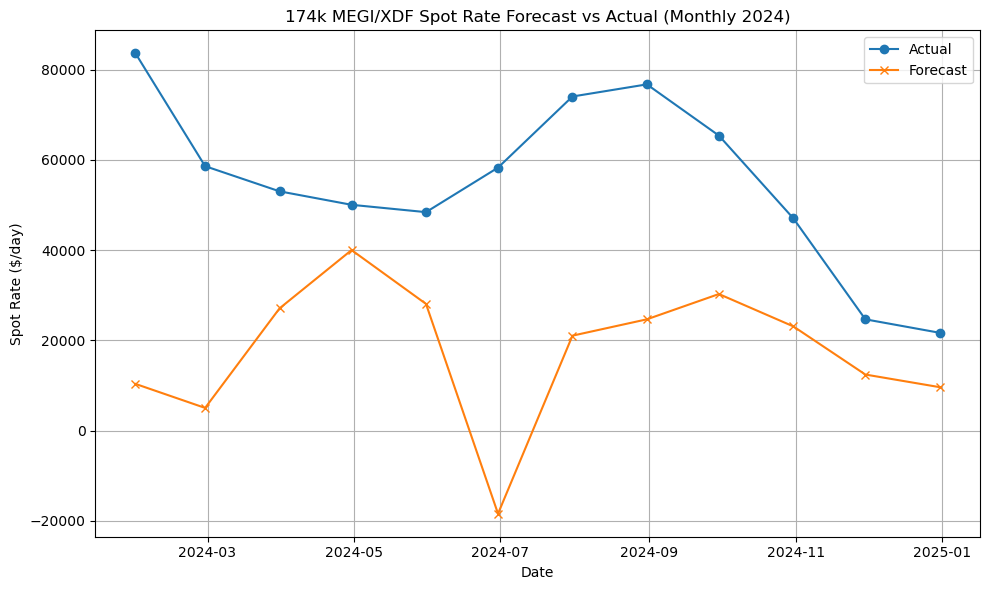

In [172]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.api import VAR

# === Load Data ===
df_main = pd.read_excel('Spot charter rates - Fearnley LNG.xlsx', sheet_name='Export')
df_extra = pd.read_csv('datatest.csv')
df_spot_rates = pd.read_excel('Spot charter rates - Fearnley LNG.xlsx', sheet_name='Export')

# === Convert Dates ===
df_main['Date'] = pd.to_datetime(df_main['Date'])
df_main.set_index('Date', inplace=True)

df_extra['Date'] = pd.to_datetime(df_extra['Date'], format='%b-%y')
df_extra.set_index('Date', inplace=True)

df_spot_rates['Date'] = pd.to_datetime(df_spot_rates['Date'])
df_spot_rates.set_index('Date', inplace=True)

# === Monthly Resampling ===
df_main = df_main.resample('M').mean()
df_extra = df_extra.resample('M').mean()
df_spot_rates = df_spot_rates.resample('M').mean()

# === Merge Necessary Variables ===
combined_df = df_main[['174k MEGI / XDF']].join(df_spot_rates[['155-165k TFDE']], how='inner')
combined_df = combined_df.join(df_extra[['LNG Orderbook (start month, CBM)']], how='inner')
combined_df.dropna(inplace=True)

# === Differencing ===
diff_df = combined_df.diff().dropna()

# === Forecast Variables ===
variables = ['174k MEGI / XDF', '155-165k TFDE', 'LNG Orderbook (start month, CBM)']

# === Training and Forecasting ===
train = diff_df[diff_df.index < '2024-01-01']
forecast_dates = pd.date_range(start='2024-01-31', periods=12, freq='M')
forecast_df = pd.DataFrame(index=forecast_dates, columns=variables)

# === Rolling Forecast Loop ===
for date in forecast_dates:
    model = VAR(train)
    results = model.fit(maxlags=2, ic='aic')
    lag_order = results.k_ar
    input_data = train.values[-lag_order:]
    forecast = results.forecast(input_data, steps=1)
    forecast_df.loc[date] = forecast[0]
    if date in diff_df.index:
        train = pd.concat([train, diff_df.loc[[date]]])

# === Reconstruct Forecast to Original Scale ===
last_val = combined_df.loc[train.index[-1]]
forecast_level = forecast_df.cumsum().add(last_val)
actual = combined_df.loc[forecast_level.index]

# === Evaluation ===
mae = mean_absolute_error(actual['174k MEGI / XDF'], forecast_level['174k MEGI / XDF'])
rmse = np.sqrt(mean_squared_error(actual['174k MEGI / XDF'], forecast_level['174k MEGI / XDF']))

print("MAE:", mae)
print("RMSE:", rmse)

# === Visualization ===
plt.figure(figsize=(10, 6))
plt.plot(actual.index, actual['174k MEGI / XDF'], label='Actual', marker='o')
plt.plot(forecast_level.index, forecast_level['174k MEGI / XDF'], label='Forecast', marker='x')
plt.title('174k MEGI/XDF Spot Rate Forecast vs Actual (Monthly 2024)')
plt.xlabel('Date')
plt.ylabel('Spot Rate ($/day)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self.

MAE: 37821.70497618358
RMSE: 41107.885144514


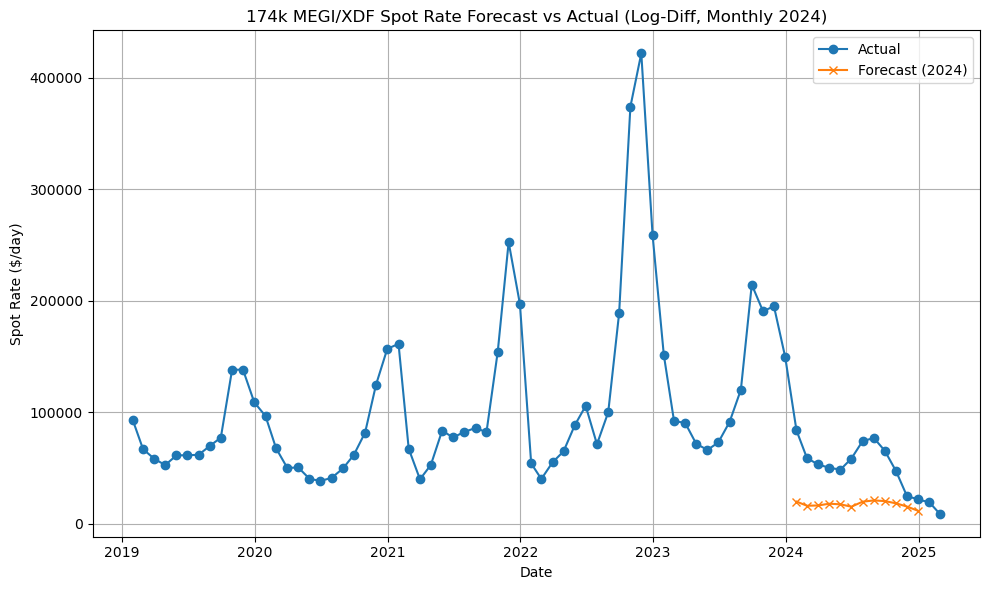

In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.api import VAR

# === Load Data ===
df_main = pd.read_excel('Spot charter rates - Fearnley LNG.xlsx', sheet_name='Export')
df_extra = pd.read_csv('datatest.csv')
df_spot_rates = pd.read_excel('Spot charter rates - Fearnley LNG.xlsx', sheet_name='Export')

# === Convert Dates ===
df_main['Date'] = pd.to_datetime(df_main['Date'])
df_main.set_index('Date', inplace=True)

df_extra['Date'] = pd.to_datetime(df_extra['Date'], format='%b-%y')
df_extra.set_index('Date', inplace=True)

df_spot_rates['Date'] = pd.to_datetime(df_spot_rates['Date'])
df_spot_rates.set_index('Date', inplace=True)

# === Monthly Resampling ===
df_main = df_main.resample('ME').mean()
df_extra = df_extra.resample('ME').mean()
df_spot_rates = df_spot_rates.resample('ME').mean()

# === Merge Necessary Variables ===
combined_df = df_main[['174k MEGI / XDF']].join(df_spot_rates[['155-165k TFDE']], how='inner')
combined_df = combined_df.join(df_extra[['LNG Orderbook (start month, CBM)']], how='inner')
combined_df.replace(0, np.nan, inplace=True)
combined_df.dropna(inplace=True)

# === Log Transformation and Differencing ===
log_combined_df = np.log(combined_df)
log_diff_df = log_combined_df.diff().dropna()

# === Forecast Variables ===
variables = ['174k MEGI / XDF', '155-165k TFDE', 'LNG Orderbook (start month, CBM)']

# === Training and Forecasting Setup ===
train = log_diff_df[log_diff_df.index < '2024-01-01']
forecast_dates = pd.date_range(start='2024-01-31', periods=12, freq='ME')
forecast_df = pd.DataFrame(index=forecast_dates, columns=variables)

# === Rolling Forecast Loop ===
for date in forecast_dates:
    model = VAR(train)
    results = model.fit(maxlags=2, ic='aic')
    lag_order = results.k_ar
    input_data = train.values[-lag_order:]
    forecast = results.forecast(input_data, steps=1)
    forecast_df.loc[date] = forecast[0]
    if date in log_diff_df.index:
        train = pd.concat([train, log_diff_df.loc[[date]]])

# === Reconstruct to Log Level, then Exponentiate ===
last_val = log_combined_df.loc[train.index[-1]]
log_forecast_level = forecast_df.cumsum().add(last_val)

# Ensure numeric data before exponentiation
log_forecast_level = log_forecast_level.astype(float)

# Convert back to original scale
forecast_level = np.exp(log_forecast_level)

# === Align Actuals and Clip Forecasts to Non-Negative ===
actual = combined_df.loc[forecast_level.index]
forecast_level = forecast_level.clip(lower=0)

# === Evaluation ===
mae = mean_absolute_error(actual['174k MEGI / XDF'], forecast_level['174k MEGI / XDF'])
rmse = np.sqrt(mean_squared_error(actual['174k MEGI / XDF'], forecast_level['174k MEGI / XDF']))

print("MAE:", mae)
print("RMSE:", rmse)

# === Visualization ===
plt.figure(figsize=(10, 6))
# Merge actuals with forecast to get full series
full_actual_series = combined_df['174k MEGI / XDF'].copy()
full_forecast_series = forecast_level['174k MEGI / XDF']

plt.plot(full_actual_series[full_actual_series.index >= '2019'], label='Actual', marker='o')
plt.plot(full_forecast_series, label='Forecast (2024)', marker='x')

plt.title('174k MEGI/XDF Spot Rate Forecast vs Actual (Log-Diff, Monthly 2024)')
plt.xlabel('Date')
plt.ylabel('Spot Rate ($/day)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self.

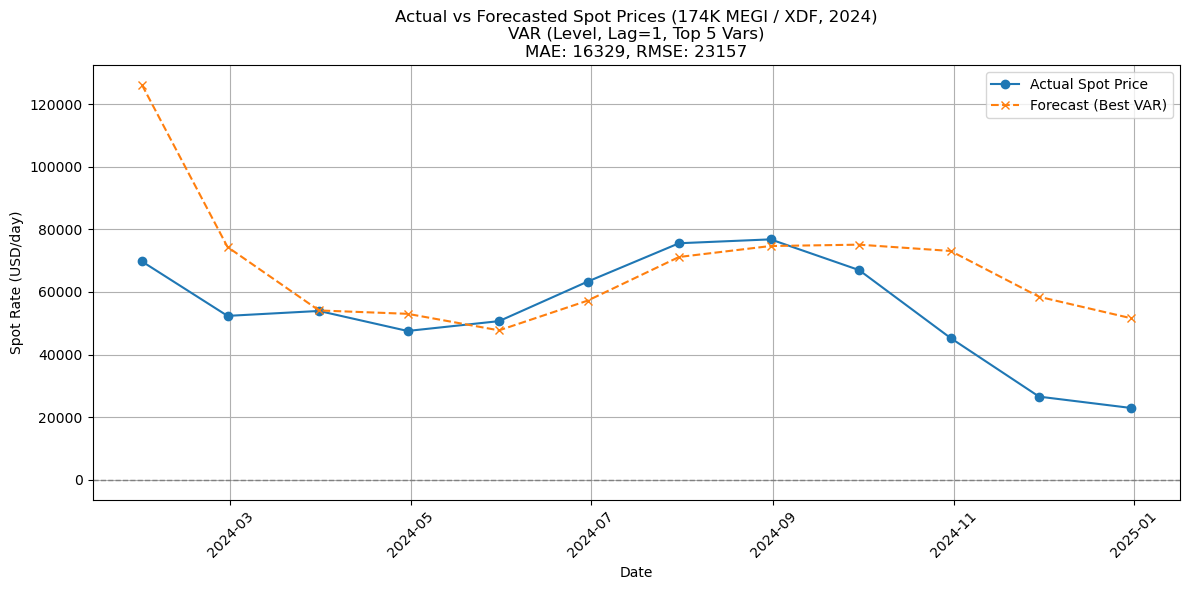

In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- Last inn data ---
df = pd.read_csv("datatest.csv")
df.columns = df.columns.str.replace("\n|\r", " ", regex=True).str.strip()
df['Date'] = pd.to_datetime(df['Date'], format='%b-%y')
df.set_index('Date', inplace=True)
df = df.apply(pd.to_numeric, errors='coerce')

# --- Definer variabler ---
vars_top5 = [
    'LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)',
    'LNG 145K CBM (Steam Turbine) Spot Rate (avg., $/day)',
    'Global price of Natural Gas, Asia (start month, MMBTU)',
    'Spread ASIA-US',
    'Global price of Natural Gas, EU (start month, MMBTU)'
]

# --- Klargjør datasett ---
df_model = df[vars_top5].dropna()
df_model_recent = df_model[df_model.index >= '2020-01-01']
index_2024 = df_model_recent[df_model_recent.index.year == 2024].index
history = df_model_recent[df_model_recent.index < '2024-01-01'].copy()

# --- Rullende forecast (lag=1) ---
rolling_forecast = []

for date in index_2024:
    model = VAR(history)
    fitted = model.fit(maxlags=1)
    forecast = fitted.forecast(history.values, steps=1)
    rolling_forecast.append(forecast[0])
    if date in df_model_recent.index:
        new_row = df_model_recent.loc[date].values.reshape(1, -1)
        history = pd.concat([history, pd.DataFrame(new_row, columns=history.columns, index=[date])])

forecast_df = pd.DataFrame(rolling_forecast, index=index_2024, columns=history.columns)

# --- Evaluer og visualiser ---
target = vars_top5[0]
forecast_series = forecast_df[target]
forecast_series.index = forecast_series.index.to_period('M').to_timestamp('M')

actual_2024 = df[target].loc['2024']
actual_2024.index = actual_2024.index.to_period('M').to_timestamp('M')

mae = mean_absolute_error(actual_2024, forecast_series)
rmse = np.sqrt(mean_squared_error(actual_2024, forecast_series))

# --- Plot ---
plt.figure(figsize=(12, 6))
plt.plot(actual_2024.index, actual_2024.values, label='Actual Spot Price', marker='o')
plt.plot(forecast_series.index, forecast_series.values, label='Forecast (Best VAR)', linestyle='--', marker='x')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title(f'Actual vs Forecasted Spot Prices (174K MEGI / XDF, 2024)\nVAR (Level, Lag=1, Top 5 Vars)\nMAE: {mae:.0f}, RMSE: {rmse:.0f}')
plt.ylabel('Spot Rate (USD/day)')
plt.xlabel('Date')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Eier\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self.

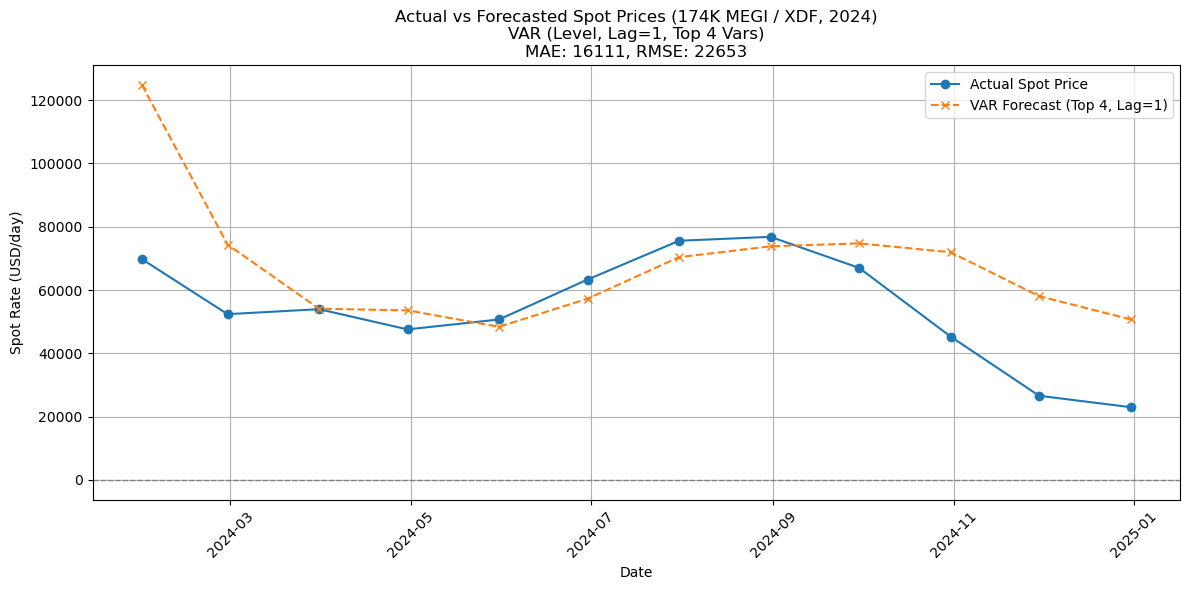

In [185]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- Load and prepare data ---
df = pd.read_csv("datatest_3.csv")
df.columns = df.columns.str.replace("\n|\r", " ", regex=True).str.strip()
df['Date'] = pd.to_datetime(df['Date'], format='%b-%Y')
df.set_index('Date', inplace=True)
df = df.apply(pd.to_numeric, errors='coerce')

# --- Define best-performing variable set ---
top4_vars = [
    'LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)',
    'LNG 145K CBM (Steam Turbine) Spot Rate (avg., $/day)',
    'Global price of Natural Gas, Asia (start month, MMBTU)',
    'Spread ASIA-US'
]

# --- Prepare dataset ---
df_model = df[top4_vars].dropna()
df_model_recent = df_model[df_model.index >= '2020-01-01']
index_2024 = df_model_recent[df_model_recent.index.year == 2024].index
history = df_model_recent[df_model_recent.index < '2024-01-01'].copy()

# --- Rolling forecast with lag=1 ---
rolling_forecast = []

for date in index_2024:
    model = VAR(history)
    fitted = model.fit(maxlags=1)
    forecast = fitted.forecast(history.values, steps=1)
    rolling_forecast.append(forecast[0])
    if date in df_model_recent.index:
        new_row = df_model_recent.loc[date].values.reshape(1, -1)
        history = pd.concat([history, pd.DataFrame(new_row, columns=history.columns, index=[date])])

forecast_df = pd.DataFrame(rolling_forecast, index=index_2024, columns=history.columns)

# --- Evaluate forecast ---
target = top4_vars[0]
forecast_series = forecast_df[target]
forecast_series.index = forecast_series.index.to_period('M').to_timestamp('M')

actual_2024 = df[target].loc['2024']
actual_2024.index = actual_2024.index.to_period('M').to_timestamp('M')

mae = mean_absolute_error(actual_2024, forecast_series)
rmse = np.sqrt(mean_squared_error(actual_2024, forecast_series))

# --- Plot ---
plt.figure(figsize=(12, 6))
plt.plot(actual_2024.index, actual_2024.values, label='Actual Spot Price', marker='o')
plt.plot(forecast_series.index, forecast_series.values, label='VAR Forecast (Top 4, Lag=1)', linestyle='--', marker='x')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title(f'Actual vs Forecasted Spot Prices (174K MEGI / XDF, 2024)\nVAR (Level, Lag=1, Top 4 Vars)\nMAE: {mae:.0f}, RMSE: {rmse:.0f}')
plt.ylabel('Spot Rate (USD/day)')
plt.xlabel('Date')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
